In [30]:
##
## Summary: In the education industry, high schools prep students for the next chapter in his/her life. 
##    Viewing university statistics and massachusetts high school statistics, 
##    do patterns exist to show patterns between the number of students in college from high schools 
##    and the average SAT scores vs average SAT score for universities?
##    Is there correlation between school accountability, SAT scores and theoretical acceptance into universities?
##    
##    The first dataset is:
##        
##        
##        
##    The second dataset is:
##        
##        

#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#Import the first dataset (Massachusetts high school)
mshs=pd.read_csv('../data/external/MA_Public_Schools_2017.csv')

#Import the second dataset (University data)
univ=pd.read_json('../data/external/schoolInfo.json')

In [31]:
#Cleaning up MA school data

#------------Dropping Columns------------
#Drop columns regarding MCAS scores
mshsFirst=mshs.iloc[:,0:31].copy()

mshsSecond=mshs.iloc[:,93:97].copy()

mshsLast=mshs.iloc[:,293:302].copy()

#also drop all demographics of students.
mshsdemo=mshs.iloc[:,51:53].copy()


#merge the tables
mshsFinal=mshsFirst.join(mshsdemo, how='outer')
mshsFinal=mshsFinal.join(mshsSecond, how='outer')
mshsFinal=mshsFinal.join(mshsLast, how='outer')

#Dropping...
#Function: column 4----1 unique values=MA
#Contact name: column 5--- not irrelevant in detecting acceptance to universities
#Address 1 & 2: column 6,7---also not irrelevant. Can generalize by town.
#Phone and Fax:col 10,11---also not irrelevant

mshsFinal=mshsFinal.drop(columns=['School Code','Function','Contact Name','Address 1','Address 2','Phone','Fax','Grade','PK_Enrollment','K_Enrollment', '1_Enrollment',
                                  '2_Enrollment','3_Enrollment','4_Enrollment','5_Enrollment','6_Enrollment',
                                  '7_Enrollment', '8_Enrollment','9_Enrollment','10_Enrollment','11_Enrollment','Accountability and Assistance Level',
                                  'Accountability and Assistance Description','District_Accountability and Assistance Level',
                                  'District_Accountability and Assistance Description','Progress and Performance Index (PPI) - High Needs Students',
                                  'District_Progress and Performance Index (PPI) - High Needs Students','District Name','District Code',
                                 'SP_Enrollment','School Type'])


##------------Remove all non high schools or nonenrollment of seniors#------------
mshsFinal=mshsFinal[mshsFinal['12_Enrollment'] > 0]

#drop the column
mshsFinal=mshsFinal.drop(columns=['12_Enrollment'])

##------------Remove all rows without SAT data and district performance progress------------
mshsFinal=mshsFinal.dropna(subset=['SAT_Tests Taken','School Accountability Percentile (1-99)'])

#Remove all rows without average SAT reading and SAT Math
mshsFinal=mshsFinal[mshsFinal['Average SAT_Reading']>0]
mshsFinal=mshsFinal[mshsFinal['Average SAT_Math']>0]

#Output MA Public School data....
#mshsFinal

In [32]:
#Cleaning up university data

#----------Dropping columns----------
#aliasNames=not relevant to viewing patterns between high school acceptance based on SAT data and demographics
#businessRepScore=most entries are NaN
#sortname=not relevant
#primaryphoto=not relevant
#primary photothumb=not relevant
#rankingdisplayname=not relevant
#rankingNoteCharacter=not relevant
#rankingNoteText=not relevant
#sortname=not relevant
#urlname=not relevant
#xwalkId=not relevant
#act-avg=not relevant
#all student demographic is not related.
#nonresponder and text=not relevant

univ=univ.drop(columns=['primaryKey','act-avg','aliasNames','businessRepScore','sortName',
                        'primaryPhoto','primaryPhotoThumb','rankingType','rankingMaxPossibleScore',
                        'rankingDisplayName','rankingNoteText','rankingNoteCharacter','sortName',
                        'urlName','xwalkId','nonResponder','nonResponderText','rankingIsTied',
                        'rankingRankStatus','engineeringRepScore','isPublic'])

#remove NaN entries in sat-avg
univ=univ.dropna(subset=['sat-avg'])

#Output university data
#univ

In [33]:
#----------Transforming High School Data----------
#Transform high school public to boolean
#The data on school type is public OR charter school.
#charter schools seen as public from federal education department
mshsFinal['Institutional Control']=True

#Change town to city column name
mshsFinal.rename(columns={'Town':'City'},inplace=True)

#Change TOTAL Enrollment to Enrollment
mshsFinal.rename(columns={'TOTAL_Enrollment':'Enrollment'},inplace=True)

#Add column categorizing high schools vs universities (will help with merge)
mshsFinal.loc[:,'schoolType']=pd.Series('high-school', index=mshsFinal.index, dtype="category")

#Adding column and calculating average SAT scores
mshsFinal.loc[:,'sat-avg']=mshsFinal['Average SAT_Reading']+mshsFinal['Average SAT_Math']

#Change to categories for proper join
mshsFinal['schoolType']=mshsFinal['schoolType'].astype("category")
mshsFinal['School Name']=mshsFinal['School Name'].astype("category")

#Rank high schools in MA based on avg SAT scores
mshsFinal=mshsFinal.sort_values(['sat-avg'], ascending=False)
#reset index to create incremental ranking
mshsFinal=mshsFinal.reset_index()

#Start ranking at 1
mshsFinal['ranking']=mshsFinal.index+1


In [34]:
#----------Transforming University Data----------
#Change column for university name, city, zip, enrollment, and private/public institution for merge
univ.rename(columns={'displayName':'School Name', 'city':'City','zip':'Zip', 
                     'state':'State','enrollment':'Enrollment',
                     'institutionalControl':'Institutional Control'}, inplace=True)

#alter column to match column of other dataset
univ['schoolType']=univ['schoolType'].astype("category")
univ['School Name']=univ['School Name'].astype("category")



In [35]:
#----------Merge datasets----------
result=pd.concat([mshsFinal,univ],axis=0,sort=False )

#----------Bin SAT Avg scores----------
#The lowest SAT is 600 and highest is 2400
bins=[600,800,1000,1200,1400,1600,1800,2000,2200,2400]
result['binned_scores']=pd.cut(result['sat-avg'],bins)

#----------------Randomize data----------------
result=result.sample(frac=1)

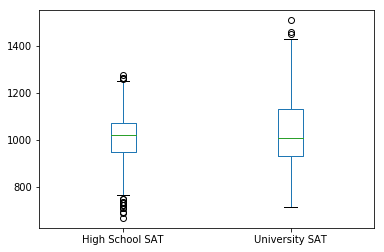

In [61]:
##----------------Plot the different average SAT scores of high schools in MA vs Universities----------------
#Plot average SAT scores 1 line is high school and 1 line is university
#export the sat-avg and School Type
SATforType=result[['schoolType','sat-avg']].copy()

#Separate high school and university SAT averages
SATforHS=SATforType.loc[SATforType['schoolType'] == 'high-school']
SATforU=SATforType.loc[SATforType['schoolType'] == 'national-universities']

#Create new Dataframe as High School and University average SAT for easy plotting
SATforType=pd.DataFrame(data={'High School SAT':SATforHS['sat-avg'], 'University SAT':SATforU['sat-avg']})

SATforType.plot.box()

#The results show the mean and the box shows 25-75% of the SAT average scores. 
#Comparing the high schools in MA and ranked universities, one can see the top SAT scores 
#for MA lacks quite a bit. Furthermore,

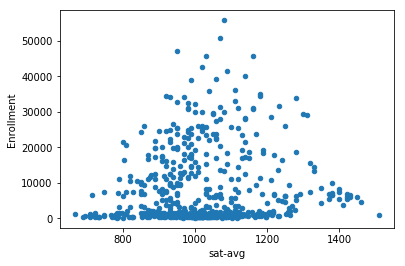

In [68]:
#----------------Viewing number of enrollment vs SAT scores----------------

EnrollvsSAT=result[['sat-avg','Enrollment','schoolType']].copy()
EnrollvsSAT.plot.scatter(x='sat-avg',y='Enrollment',)
#TODO: Set dots as different institution types
#plot.kde
#

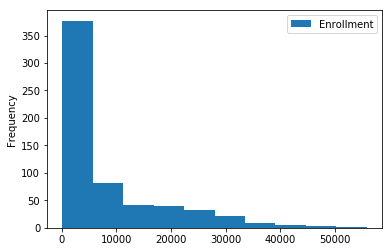

In [55]:
EnrollvsSAT=result[['sat-avg','Enrollment']].copy()
EnrollvsSAT.plot.hist(x='sat-avg')

In [44]:
result.columns

Index(['index', 'School Name', 'City', 'State', 'Zip', 'Enrollment',
       'Average Class Size', 'Number of Students', 'SAT_Tests Taken',
       'Average SAT_Reading', 'Average SAT_Writing', 'Average SAT_Math',
       'School Accountability Percentile (1-99)',
       'Progress and Performance Index (PPI) - All Students',
       'District_Progress and Performance Index (PPI) - All Students',
       'Institutional Control', 'schoolType', 'sat-avg', 'ranking',
       'acceptance-rate', 'cost-after-aid', 'hs-gpa-avg', 'overallRank',
       'percent-receiving-aid', 'rankingDisplayRank', 'rankingDisplayScore',
       'rankingSortRank', 'region', 'tuition', 'binned_scores'],
      dtype='object')